## Predict if the server will be hacked

All countries across the globe have adapted to means of digita payments. And with increased volume of digita payments, hacking has become a pretty common event wherein the hacker can try to hack your details just with the phone number linked to your bank account. However, there is data with some anonymized variables based on which one can predict that the hack is going to happen.

The goal is to build a predictive model which can identify a pattern in these variables and suggest that a hack is going to happen so that cybersecurity can somehow stop it before it actually happens.

**DATA**

|COLUMN|DESCRIPTION|
|----|----|
|INCIDENT_ID|Unique identifier for an incident log|
|DATE|Date of incident occurence|
|X_1- X_15|Anonymized logging parameters|
|MULTIPLE_OFFENSE|Target: Indicates if incident was a hack [1:YES;0:NO]|

## Importing necessary libraries

In [1]:
import warnings
from pandas_profiling import ProfileReport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
warnings.filterwarnings('ignore')

### Importing Data Labelling Libraries

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

## Data Loading and Cleaning

In [3]:
# Loading the train and test dataset
data_train = pd.read_csv(r'C:\Users\sumir\Downloads\Dataset\Train.csv',
                         delimiter=',')
data_test = pd.read_csv(r'C:\Users\sumir\Downloads\Dataset\Test.csv',
                        delimiter=',')

print('Shape of the data is: ', data_train.shape)
print('Shape of the data is: ', data_test.shape)

Shape of the data is:  (23856, 18)
Shape of the data is:  (15903, 17)


In [4]:
# Displaying top 5 rows of the train dataset
data_train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [5]:
# Displaying last 5 rows of the train dataset
data_train.tail()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
23851,CR_88991,11-JAN-02,1,47,48,7,3,15,10,1,5,1,174,0.0,98,29,34,1
23852,CR_46369,05-FEB-97,0,33,32,2,1,5,6,0,5,1,174,0.0,112,29,43,1
23853,CR_157556,03-APR-12,0,25,25,9,0,3,5,1,6,1,174,0.0,10,29,18,1
23854,CR_103180,25-JAN-04,0,39,39,6,5,2,7,1,6,1,127,0.0,112,103,43,1
23855,CR_22575,08-NOV-94,7,36,34,2,1,9,8,0,5,1,249,1.0,92,29,34,1


In [6]:
# Info about the dataset
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null object
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: float64(1), int64(15), object(2)
memory usage: 3.3+ MB


In [7]:
# Creating profile report for the train dataset
profile_train = ProfileReport(data_train, title="Training data report")

In [8]:
profile_train

#### Observations
From the report above we have some clear observations, which are listed as below:
1. Datetime value is a categorical column, which has to be converted to datetime column.
2. Column X_1 has 79.8% zero values. It should be looked at the further.
2. Columns X_2 and X_3 are higly correlated, so we have to further analyse it.
3. Similarly columns X_10 and X_12 and X_6 and X_7 are correlated too.
4. Column X_10 and X_12 have higly skewed values.
5. Column X_12 has 182 missing values.
6. The target column "MULTIPLE_OFFENSE" clearly shows that it is an imbalanced dataset as we have more numbers of "YES"  (target class) than "NO" (non-target class).
7. Column X_12 has float dtype, for consistency it can be converted to integer value.

In [9]:
# Analyzing Target Column for Class Distribution
def class_imbalance(target):
    class_values = (target.value_counts() / target.value_counts().sum()) * 100
    return class_values


class_imbalance(data_train['MULTIPLE_OFFENSE'])

1    95.523139
0     4.476861
Name: MULTIPLE_OFFENSE, dtype: float64

The class distribution in the target is ~95:4. This is a clear indication of imbalance.

In [10]:
# Converting DATE column dtype to datetime values
data_train['DATE'] = pd.to_datetime(data_train['DATE'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null datetime64[ns]
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(15), object(1)
memory usage: 3.3+ MB


In [11]:
# Extracting Year
data_train['YEAR'] = data_train['DATE'].dt.year

# Extracting Month
data_train['MONTH'] = data_train['DATE'].dt.month

# Extracting Day
data_train['DAY'] = data_train['DATE'].dt.day

In [12]:
# Handling missing values in column X_12
data_train['X_12'] = data_train['X_12'].fillna(1)

In [13]:
# Converting datatype column X_12
data_train['X_12'] = data_train['X_12'].astype('int')

In [14]:
# Dropping duplicate rows if any in the dataset
data_train.drop_duplicates(keep=False, inplace=True)

In [15]:
data_train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,YEAR,MONTH,DAY
0,CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1,92,29,36,0,2004,7,4
1,CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1,103,142,34,1,2017,7,18
2,CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1,110,93,34,1,2017,3,15
3,CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1,72,29,34,1,2009,2,13
4,CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0,112,29,43,1,2005,4,13


## Exploratory Data Analysis

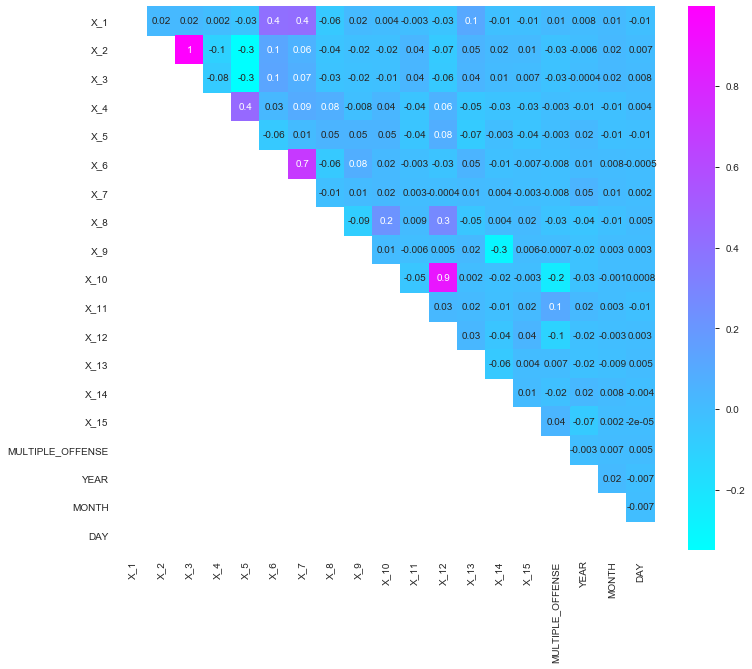

In [16]:
# Creating a correlation heatmap for training data
plt.figure(figsize=(12, 10))
cor = data_train.corr()
mask = np.tril(cor)
sns.heatmap(cor, fmt='.1g', annot=True, cmap='cool', mask=mask)

#### Observations
From the above correlation heatmap, we can confirm our observation that columns X_2 and X_3 are highly correlated. That corr ratio of X_6 and X_7 is 0.7 and that for X_10 and X_12 is 0.88. We need to further evaluate these columns.

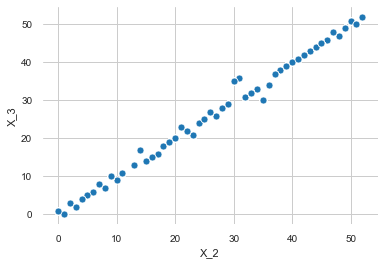

In [17]:
# Scatterplot showing the relationship between our variables
sns.scatterplot(data_train['X_2'], data_train['X_3'])

- From all the data presentated so far, it can be concluded that columns X_2 and X_3 are positively correlated and that we have to drop one of the columns.

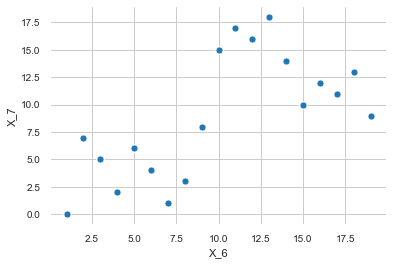

In [18]:
# Scatterplot showing the relationship between our variables
sns.scatterplot(data_train['X_6'], data_train['X_7'])

- From the visualization that we see above, there is no clear evidence to drop either columns as shown in correlation plot.

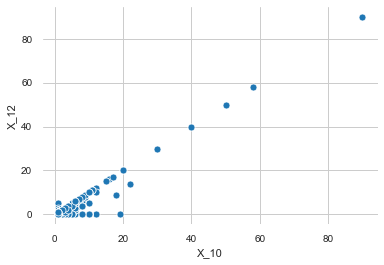

In [19]:
# Scatterplot showing the relationship between our variables
sns.scatterplot(data_train['X_10'], data_train['X_12'])

- From all the data presentated so far, it can be concluded that columns X_10 and X_12 are positively correlated and that we have to drop one of the columns.

In [20]:
# Observing the correlation of the attributes with the target
cor_target = abs(cor["MULTIPLE_OFFENSE"])
cor_target

X_1                 0.014034
X_2                 0.027293
X_3                 0.027218
X_4                 0.002921
X_5                 0.003450
X_6                 0.007903
X_7                 0.008036
X_8                 0.033397
X_9                 0.000748
X_10                0.242596
X_11                0.105088
X_12                0.113004
X_13                0.006512
X_14                0.015267
X_15                0.044916
MULTIPLE_OFFENSE    1.000000
YEAR                0.002755
MONTH               0.006736
DAY                 0.004736
Name: MULTIPLE_OFFENSE, dtype: float64

From the above observation, we can see that most columns are not highly correlated with the target column, except for column X_10 which is shows some correlation with the target variable.

In [21]:
# Average value of numerical features in case of hack
data_train[data_train['MULTIPLE_OFFENSE'] == 1].mean()

X_1                    0.488152
X_2                   24.701159
X_3                   24.548271
X_4                    4.274882
X_5                    2.454143
X_6                    6.146524
X_7                    4.869756
X_8                    0.961954
X_9                    4.923907
X_10                   1.186019
X_11                 209.071002
X_12                   0.945805
X_13                  85.276286
X_14                  72.531201
X_15                  33.546296
MULTIPLE_OFFENSE       1.000000
YEAR                2004.244471
MONTH                  6.513648
DAY                   15.573635
dtype: float64

### Univariate Analysis of the continous features

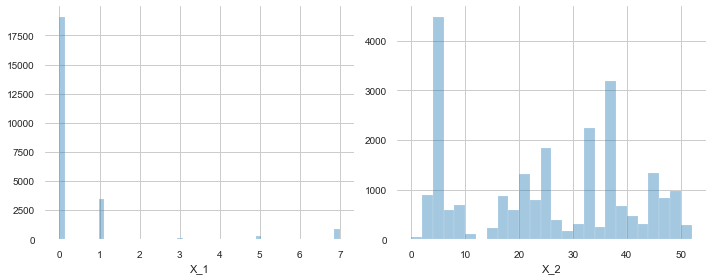

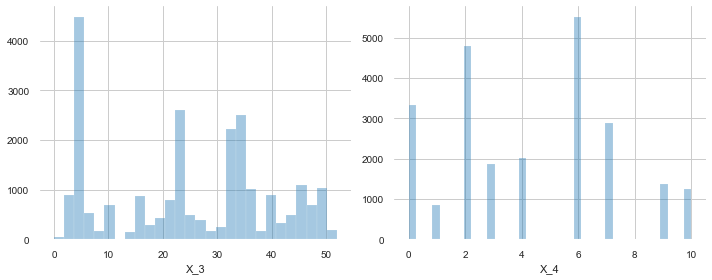

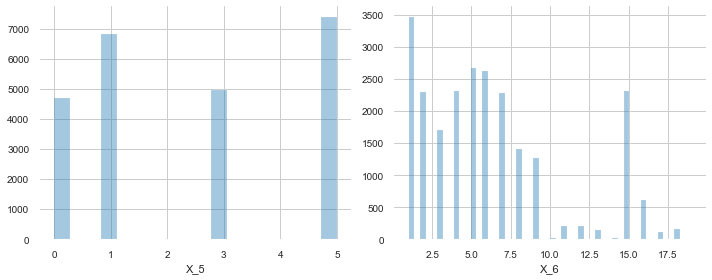

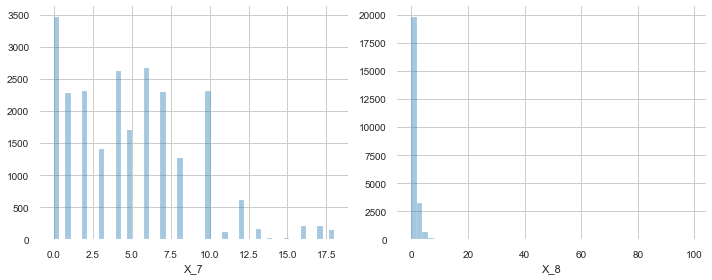

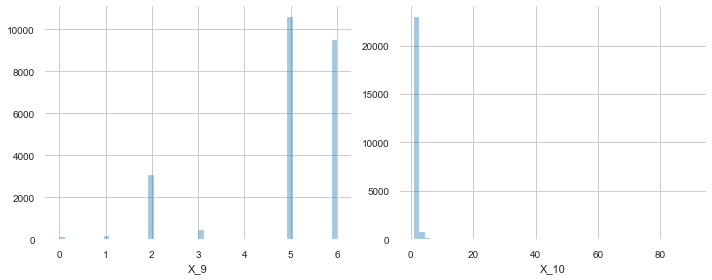

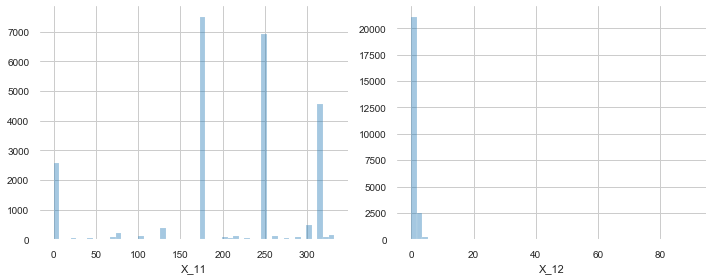

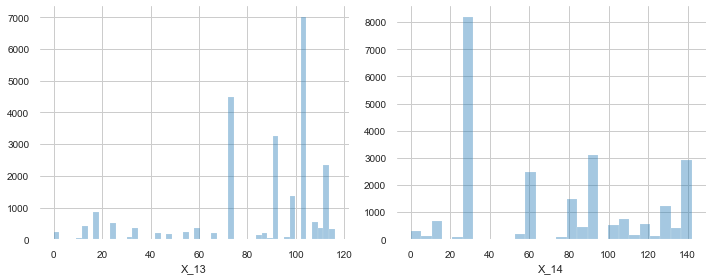

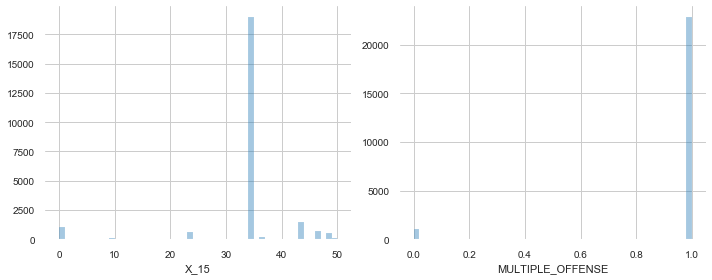

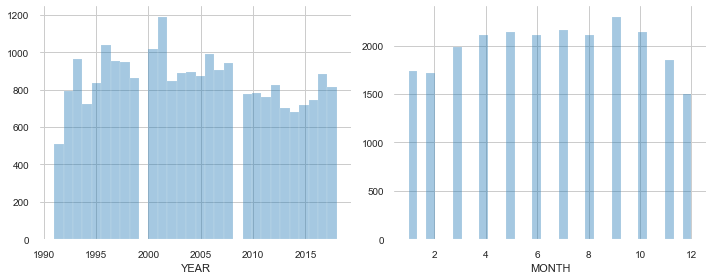

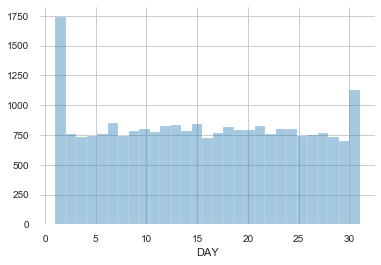

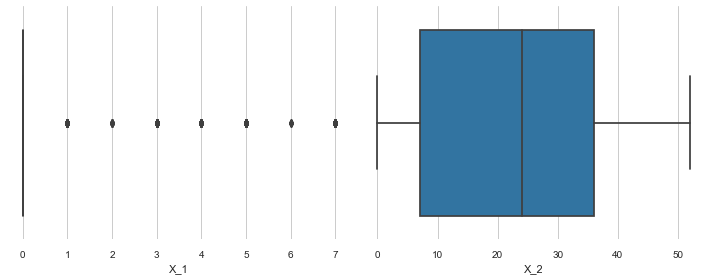

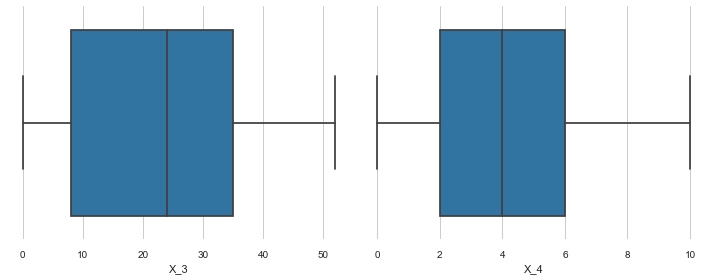

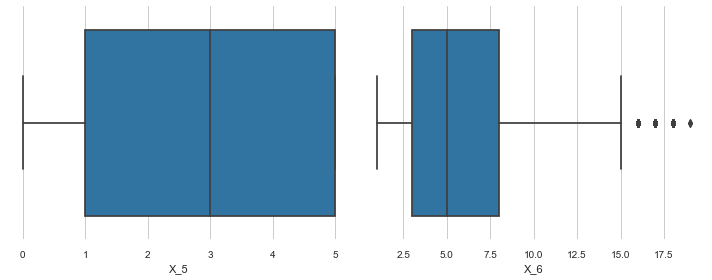

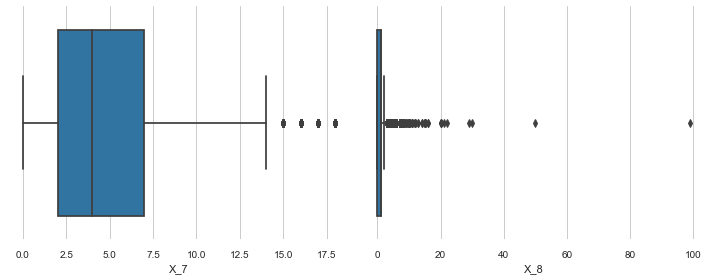

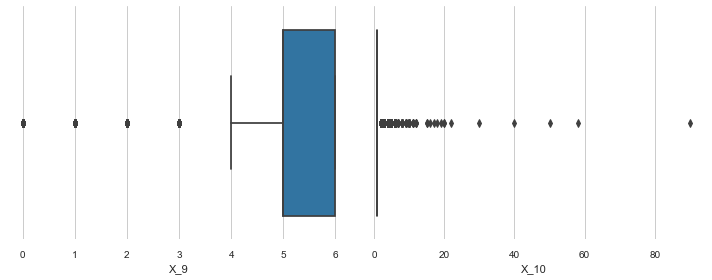

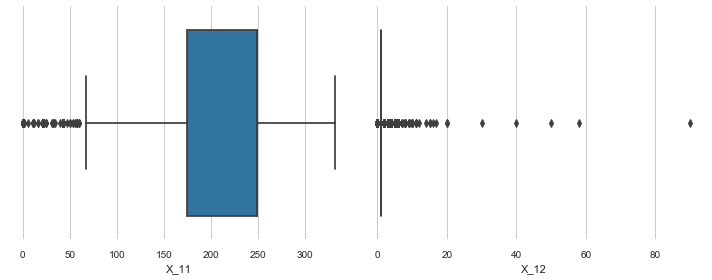

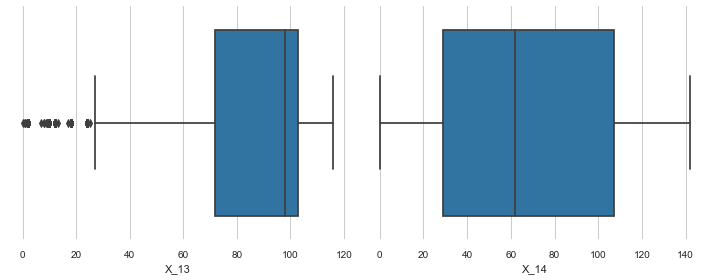

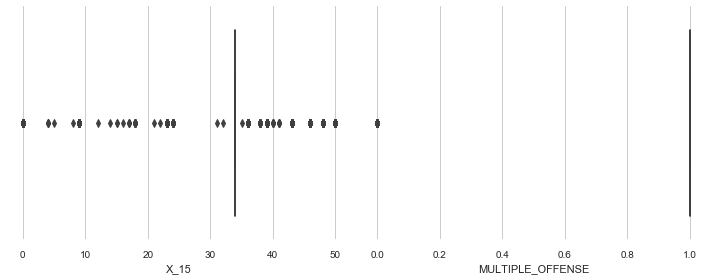

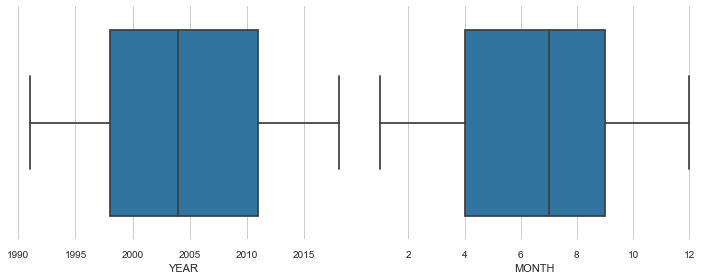

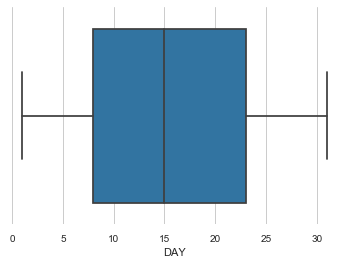

In [22]:
# Function to plot histograms
def plot_continuous_columns(dataframe):
    numeric_columns = dataframe.select_dtypes(
        include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]

    for i in range(0, len(numeric_columns), 2):
        if len(numeric_columns) > i + 1:
            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)
            sns.distplot(dataframe[numeric_columns[i + 1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)


# Function to plot boxplots


def plot_box_plots(dataframe):
    numeric_columns = dataframe.select_dtypes(
        include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]

    for i in range(0, len(numeric_columns), 2):
        if len(numeric_columns) > i + 1:
            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)
            sns.boxplot(dataframe[numeric_columns[i + 1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])


plot_continuous_columns(data_train)
plot_box_plots(data_train)

- From the above histogram and boxplots, we can infer the following:
1. columns X_10 and X_12 are heavily skewed. 
2. Since column X_1 majorily contains zeros and single values with less count, as well as low variance we can drop this column as it will be of no help in prediction.

#### Observations
- From our analysis so far we can conclude the following things:
1. We can drop columns X_1, X_3 and columns X_12 from modelling.
2. We will be better off when our features are on a relatively similar scale and normally distributed. In that case we need to scale our feature columns

In [23]:
# Dropping columns X_1, X_3 and X_12 from the train dataset
data_train = data_train.drop(['X_1', 'X_3', 'X_12'], 1)

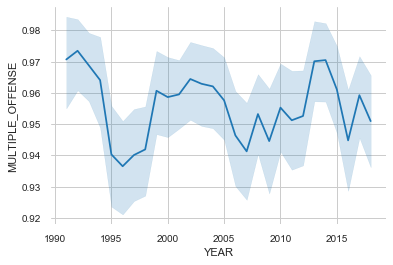

In [24]:
# Visualization of YEAR with the target column
sns.lineplot(x='YEAR', y='MULTIPLE_OFFENSE', data=data_train)

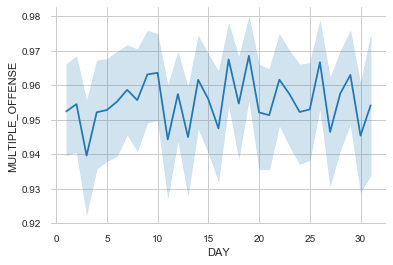

In [25]:
# Visualization of DAY with the target column
sns.lineplot(x='DAY', y='MULTIPLE_OFFENSE', data=data_train)

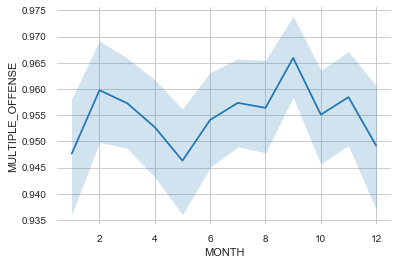

In [26]:
# Visualization of MONTH with the target column
sns.lineplot(x='MONTH', y='MULTIPLE_OFFENSE', data=data_train)

In [27]:
# Converting DATE column dtype to datetime values
data_test['DATE'] = pd.to_datetime(data_test['DATE'])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15903 entries, 0 to 15902
Data columns (total 17 columns):
INCIDENT_ID    15903 non-null object
DATE           15903 non-null datetime64[ns]
X_1            15903 non-null int64
X_2            15903 non-null int64
X_3            15903 non-null int64
X_4            15903 non-null int64
X_5            15903 non-null int64
X_6            15903 non-null int64
X_7            15903 non-null int64
X_8            15903 non-null int64
X_9            15903 non-null int64
X_10           15903 non-null int64
X_11           15903 non-null int64
X_12           15776 non-null float64
X_13           15903 non-null int64
X_14           15903 non-null int64
X_15           15903 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(14), object(1)
memory usage: 2.1+ MB


In [28]:
# Dropping columns X_1, X_3 and X_12 from the test dataset
data_test = data_test.drop(['X_1', 'X_3', 'X_12'], 1)

## Fit Vanilla Classification Models
Since there are many classfication algorithms in machine learning,we will be using the main ones given below.
The function written below takes the features, target and the classification model as the input parameters and internally splits them into training data and validation data. After that it standaridizes the data then fits the classification model on the train data and then makes a prediction on the validation data and outputs the 'recall_score' for this prediction. P.s For the train test split sampling is stratified rather than random to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set.

In [29]:
def run_model(predictors, target, model):
    '''
    Performs model training and tests using recall_score 
    returns score
    '''
    x_train, x_test, y_train, y_test = train_test_split(predictors,
                                                        target,
                                                        test_size=0.2,
                                                        stratify=target,
                                                        random_state=42)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    recall = recall_score(y_test, y_pred)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('ROC_AUC_SCORE is', roc_auc_score(y_test, y_pred))

    return recall


# Predictors
X = data_train.drop(
    ['MULTIPLE_OFFENSE', 'DATE', 'YEAR', 'MONTH', 'DAY', 'INCIDENT_ID'], 1)

# Target
y = data_train['MULTIPLE_OFFENSE']

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {
    'Logistic Regression': LogisticRegression,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier,
    'Gradient Boosting': GradientBoostingClassifier
}

for i in models.items():
    # run model
    model = i[1]()
    recall = run_model(X, y, model)  # train and returns recall test score
    print('Recall Score = %.2f' % (recall * 100) + ' %\nOn Model - \n' +
          str(i[0]))
    print('====' * 20)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.05      0.08       214
           1       0.96      1.00      0.98      4558

    accuracy                           0.95      4772
   macro avg       0.67      0.52      0.53      4772
weighted avg       0.93      0.95      0.94      4772

Confusion Matrix:
[[  10  204]
 [  16 4542]]
ROC_AUC_SCORE is 0.5216093302112339
Recall Score = 99.65 %
On Model - 
Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.99      0.99      0.99      4772
weighted avg       1.00      1.00      1.00      4772

Confusion Matrix:
[[ 211    3]
 [   4 4554]]
ROC_AUC_SCORE is 0.9925518652630889
Recall Score = 99.91 %
On Model - 
Decision Tree
Classification Report:
           

- From the above modelling run we observe that except for logistic regression all models are giving a good recall_score  on the training data. I would like to try oversampling for train data since we have class imbalance.

- There many oversampling methods in machine learning, but in our case I will use RandomOverSampling(ROS) and SMOTE with Logistic regression as our algorithm.

### RandomOverSampling with Logistic Regression

In [30]:
def ros_logistic(Predictor, Target):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)

    lr = LogisticRegression(random_state=42)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_sample(X_train, y_train)

    lr.fit(X_ros, y_ros)
    y_pred = lr.predict(X_test)
    print('CLASSIFICATION REPORT is ', classification_report(y_test, y_pred))
    print('RECALL SCORE is ', recall_score(y_test, y_pred))
    print('ROC_AUC_SCORE is ', roc_auc_score(y_test, y_pred))
    print('CONFUSION MATRIX is ', confusion_matrix(y_test, y_pred))


ros_logistic(X, y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.28      0.88      0.43       214
           1       0.99      0.89      0.94      4558

    accuracy                           0.89      4772
   macro avg       0.64      0.89      0.68      4772
weighted avg       0.96      0.89      0.92      4772

RECALL SCORE is  0.8944712593242651
ROC_AUC_SCORE is  0.8864879661107306
CONFUSION MATRIX is  [[ 188   26]
 [ 481 4077]]


### SMOTE with Logistic Regression

In [31]:
def smote_logistic(Predictor, Target):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)

    lr = LogisticRegression(random_state=42)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    sm = SMOTE(random_state=42)
    X_sm, y_sm = sm.fit_sample(X_train, y_train)

    lr.fit(X_sm, y_sm)
    y_pred = lr.predict(X_test)
    print('CLASSIFICATION REPORT is ', classification_report(y_test, y_pred))
    print('RECALL SCORE is ', recall_score(y_test, y_pred))
    print('ROC_AUC_SCORE is ', roc_auc_score(y_test, y_pred))
    print('CONFUSION MATRIX is ', confusion_matrix(y_test, y_pred))


smote_logistic(X, y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.28      0.88      0.43       214
           1       0.99      0.90      0.94      4558

    accuracy                           0.89      4772
   macro avg       0.64      0.89      0.68      4772
weighted avg       0.96      0.89      0.92      4772

RECALL SCORE is  0.8953488372093024
ROC_AUC_SCORE is  0.8869267550532492
CONFUSION MATRIX is  [[ 188   26]
 [ 477 4081]]


- From our oversampling method we see an improvement in recall score. We can try feature selection to see if we can improve our score.

## Feature Selection

### Feature selection using RFE
RFE is a wrapper method that uses the model to identify the best features.

- The function  `feature selection` takes four parameters `predictors`, `target`, `model` and the `number_of_features`. The parameter `number_of_features` is used for explicitly stating the number of features you want to specify inside the RFE object. For the below task, I have inputted 10 feature.

In [32]:
# USING RFE FOR FEATURE SELECTION
def feature_selection(predictors, target, number_of_features, model):

    models = model()
    rfe = RFE(models, number_of_features)
    rfe = rfe.fit(X, y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    plt.show()
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values == 1].index.tolist())
    print('====' * 30)


# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {
    'Logistic Regression': LogisticRegression,
    'Decision Tree': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier,
    'Gradient Boosting': GradientBoostingClassifier
}

# Selecting 10 number of features
for i in models.items():
    feature_selection(X, y, 10, i[1])

Features  to be selected for Logistic Regression are:
['X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_13', 'X_15']
Features  to be selected for Decision Tree are:
['X_2', 'X_4', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_13', 'X_14', 'X_15']
Features  to be selected for Random Forest are:
['X_2', 'X_4', 'X_6', 'X_7', 'X_8', 'X_10', 'X_11', 'X_13', 'X_14', 'X_15']
Features  to be selected for XGBoost are:
['X_2', 'X_4', 'X_5', 'X_6', 'X_8', 'X_10', 'X_11', 'X_13', 'X_14', 'X_15']
Features  to be selected for Gradient Boosting are:
['X_2', 'X_4', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_13', 'X_14', 'X_15']


- From the observation from applying all algorithms, I hav decided to pursue both XGBOOST and gradient boosting for further modeling, alongwith features identified from RFE.

### SMOTE WITH XGBOOST

In [33]:
def xgboost(dataframe, target):
    X = dataframe
    y = target

    x_train, x_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    smote = SMOTE(random_state=42)
    X_sm, y_sm = smote.fit_sample(x_train, y_train)

    model = XGBClassifier(n_estimators=50, max_depth=4, random_state=42)
    model.fit(X_sm, y_sm)
    y_pred = model.predict(x_test)

    print('CLASSIFICATION REPORT is ', classification_report(y_test, y_pred))
    print('RECALL SCORE is ', recall_score(y_test, y_pred))
    print('ROC_AUC_SCORE is ', roc_auc_score(y_test, y_pred))
    print('CONFUSION MATRIX is ', confusion_matrix(y_test, y_pred))


xgboost(X, y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.98      1.00      0.99       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.99      1.00      0.99      4772
weighted avg       1.00      1.00      1.00      4772

RECALL SCORE is  0.9989030276437034
ROC_AUC_SCORE is  0.9994515138218517
CONFUSION MATRIX is  [[ 214    0]
 [   5 4553]]


### SMOTE WITH XGBOOST 
Here I am applying smote with xgboost but with features selected from RFE

In [34]:
xgboost(
    X[[
        'X_2', 'X_4', 'X_5', 'X_6', 'X_8', 'X_10', 'X_11', 'X_13', 'X_14',
        'X_15'
    ]], y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.98      1.00      0.99       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.99      1.00      0.99      4772
weighted avg       1.00      1.00      1.00      4772

RECALL SCORE is  0.9989030276437034
ROC_AUC_SCORE is  0.9994515138218517
CONFUSION MATRIX is  [[ 214    0]
 [   5 4553]]


### SMOTE WITH Gradient Boosting

In [35]:
def gradient_boosting(dataframe, target):
    X = dataframe
    y = target

    x_train, x_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    smote = SMOTE(random_state=42)
    X_sm, y_sm = smote.fit_sample(x_train, y_train)

    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_sm, y_sm)
    y_pred = model.predict(x_test)

    print('CLASSIFICATION REPORT is ', classification_report(y_test, y_pred))
    print('RECALL SCORE is ', recall_score(y_test, y_pred))
    print('ROC_AUC_SCORE is ', roc_auc_score(y_test, y_pred))
    print('CONFUSION MATRIX is ', confusion_matrix(y_test, y_pred))


gradient_boosting(X, y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.93      1.00      0.96       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.96      1.00      0.98      4772
weighted avg       1.00      1.00      1.00      4772

RECALL SCORE is  0.9962702939885915
ROC_AUC_SCORE is  0.9981351469942957
CONFUSION MATRIX is  [[ 214    0]
 [  17 4541]]


### SMOTE WITH Gradient Boosting
Here I am applying smote with gradient boosting but with features selected from RFE

In [36]:
gradient_boosting(
    X[[
        'X_2', 'X_4', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_13', 'X_14',
        'X_15'
    ]], y)

CLASSIFICATION REPORT is                precision    recall  f1-score   support

           0       0.94      1.00      0.97       214
           1       1.00      1.00      1.00      4558

    accuracy                           1.00      4772
   macro avg       0.97      1.00      0.98      4772
weighted avg       1.00      1.00      1.00      4772

RECALL SCORE is  0.9971478718736287
ROC_AUC_SCORE is  0.9985739359368144
CONFUSION MATRIX is  [[ 214    0]
 [  13 4545]]


## Prediction on Test Data

In [37]:
X_train_n = data_train.drop([
    'MULTIPLE_OFFENSE', 'DATE', 'YEAR', 'MONTH', 'DAY', 'INCIDENT_ID', 'X_7',
    'X_9'
], 1)
y_train_n = data_train['MULTIPLE_OFFENSE']
X_test_n = data_test.drop(['DATE', 'INCIDENT_ID', 'X_7', 'X_9'], 1)
X_train_n.shape, y_train_n.shape, X_test_n.shape

((23856, 10), (23856,), (15903, 10))

In [38]:
xgb = XGBClassifier(n_estimators=50, max_depth=4, random_state=42)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_n)
X_test_sc = sc.transform(X_test_n)
sm = SMOTE(random_state=42)
X_train_sample, y_train_sample = sm.fit_sample(X_train_sc, y_train_n)
xgb.fit(X_train_sample, y_train_sample)
y_pred_n = xgb.predict(X_test_sc)

In [39]:
submission = pd.DataFrame({
    "INCIDENT_ID": data_test["INCIDENT_ID"],
    "MULTIPLE_OFFENSE": y_pred_n
})
submission.to_csv(
    r'C:\Users\sumir\Downloads\HackerEarth_MachineLearning\sample_submission.csv', index=False)